In [1]:
import sys
sys.path.append('..')

import numpy as np
import os
from time import time
from collections import Counter
import random
from matplotlib import pyplot as plt

from lib.data_utils import shuffle
#from lib.config import data_dir

def mnist():
    fd = open(os.path.join('train-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trX = loaded[16:].reshape((60000,28*28)).astype(float)

    fd = open(os.path.join('train-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trY = loaded[8:].reshape((60000))

    fd = open(os.path.join('t10k-images.idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teX = loaded[16:].reshape((10000,28*28)).astype(float)

    fd = open(os.path.join('t10k-labels.idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teY = loaded[8:].reshape((10000))
    
    trY = np.asarray(trY)
    teY = np.asarray(teY)

    return trX, teX, trY, teY

def mnist_with_valid_set():
    trX, teX, trY, teY = mnist()

    trX, trY = shuffle(trX, trY)
    vaX = trX[50000:]
    vaY = trY[50000:]
    trX = trX[:50000]
    trY = trY[:50000]

    return trX, vaX, teX, trY, vaY, teY

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmp5kdnxi/265abc51f7c376c224983485238ff1a5.lib and object C:/Users/p2admin/AppData/Local/Theano/compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_62_Stepping_4_GenuineIntel-2.7.12-64/tmp5kdnxi/265abc51f7c376c224983485238ff1a5.exp

Using gpu device 0: Quadro K2000 (CNMeM is disabled, cuDNN 5005)


In [2]:
#data_dir='/home/dcgan_code-master/mnist'
import theano
theano.config.floatX='float32'
theano.config.floatX

'float32'

In [22]:
trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()
import cv2
data2=np.zeros((1000,64*64))
trX=trX
%matplotlib inline
for i in range(1000):
    XXX=trX[i,:].reshape(28,28)
    temp=cv2.resize(XXX,(64,64))
    #temp[temp>=0.5]=1
    #temp[temp<=0.5]=0
    temp=temp.reshape(-1)
    data2[i,:]=np.round(temp/max(temp)*255.)

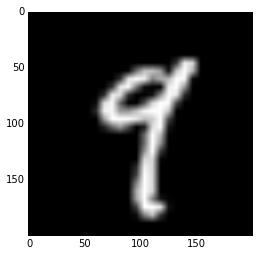

In [79]:
np.set_printoptions(threshold='nan')
plt.imshow(data2[0].reshape(200,200),'gray')
#plt.imshow(trX[0].reshape(28,28),'gray')

In [4]:
import numpy as np
import theano
import theano.tensor as tensor
from theano.tensor.signal.pool import pool_2d
from theano.tensor.nnet import conv2d

def conv( x, w, b=None ):
    s = int(np.floor(w.get_value().shape[-1]/2.))
    z = conv2d(x, w, border_mode='full')[:, :, s:-s, s:-s]
    if b is not None:
        z += b.dimshuffle('x', 0, 'x', 'x')
    
    return z
        
def max_pool( x, size, ignore_border=False ):
    return pool_2d( x, size, ignore_border=ignore_border )

def rectify( x ):
    return (x + abs(x)) / 2.0

def batchnorm( x, g=None, b=None, eps=1e-8 ):
    if x.ndim == 4:
        m = tensor.mean(x, axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')
        v = tensor.mean(tensor.sqr(x - m), 
                          axis=[0, 2, 3]).dimshuffle('x', 0, 'x', 'x')

        x = (x - m) / tensor.sqrt( v + eps )
        if g is not None and b is not None:
            x = x*g.dimshuffle('x', 0, 'x', 'x') + b.dimshuffle('x', 0, 'x', 'x')

    elif x.ndim == 2:
        m = tensor.mean(x, axis=0)
        v = tensor.mean(tensor.sqr(x - m), axis=0)

        x = (x - m) / tensor.sqrt( v + eps )
        if g is not None and b is not None:
            x = x*g + b

    return x

def depool( x, factor=2 ):
    """
    This code is from 
    https://gist.github.com/kastnerkyle/f3f67424adda343fef40
    """
    output_shape = [
        x.shape[1],
        x.shape[2]*factor,
        x.shape[3]*factor
    ]
    stride = x.shape[2]
    offset = x.shape[3]
    in_dim = stride * offset
    out_dim = in_dim * factor * factor

    upsamp_matrix = tensor.zeros((in_dim, out_dim))
    rows = tensor.arange(in_dim)
    cols = rows*factor + (rows/stride * factor * offset)
    upsamp_matrix = tensor.set_subtensor(upsamp_matrix[rows, cols], 1.)

    flat = tensor.reshape(x, (x.shape[0], output_shape[0], x.shape[2] * x.shape[3]))

    up_flat = tensor.dot(flat, upsamp_matrix)
    upsamp = tensor.reshape(up_flat, (x.shape[0], output_shape[0],
                                      output_shape[1], output_shape[2]))

    return upsamp

def full_conn( x, w, b=None ):
    return tensor.dot( x, w ) + b

def leaky_rectify( x, leak=0.2 ):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * x + f2 * abs(x) 

In [63]:
trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()


In [23]:
import sys
sys.path.append('..')

import os
import json
from time import time
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.externals import joblib

import theano
import theano.tensor as T
from theano.sandbox.cuda.dnn import dnn_conv

from lib import activations
from lib import updates
from lib import inits
from lib.vis import grayscale_grid_vis
from lib.rng import py_rng, np_rng
from lib.ops import batchnorm, conv_cond_concat, deconv, dropout
from lib.theano_utils import floatX, sharedX
from lib.data_utils import OneHot, shuffle, iter_data
from lib.metrics import nnc_score, nnd_score

trX, vaX, teX, trY, vaY, teY = mnist_with_valid_set()

#trX=data2
trX = data2[0:1000]
vaX = floatX(vaX[0:1000])/255.

k = 1             # # of discrim updates for each gen update
l2 = 2.5e-5       # l2 weight decay
b1 = 0.5          # momentum term of adam
nc = 1            # # of channels in image
ny = 10           # # of classes
nbatch = 100      # # of examples in batch
npx = 64          # # of pixels width/height of images
nz = 100          # # of dim for Z
ngfc = 1024       # # of gen units for fully connected layers
ndfc = 1024       # # of discrim units for fully connected layers
ngf = 64          # # of gen filters in first conv layer
ndf = 64          # # of discrim filters in first conv layer
nx = npx*npx*nc   # # of dimensions in X
niter = 100       # # of iter at starting learning rate
niter_decay = 100 # # of iter to linearly decay learning rate to zero
lr = 0.0002       # initial learning rate for adam
ntrain, nval, ntest = len(trX), len(vaX), len(teX)

def transform(X):
    return (floatX(X)/255.).reshape(-1, nc, npx, npx)

def inverse_transform(X):
    X = X.reshape(-1, npx, npx)
    return X

relu = activations.Rectify()
sigmoid = activations.Sigmoid()
lrelu = activations.LeakyRectify()
bce = T.nnet.binary_crossentropy

gifn = inits.Normal(scale=0.02)
difn = inits.Normal(scale=0.02)
gain_ifn = inits.Normal(loc=1., scale=0.02)
bias_ifn = inits.Constant(c=0.)


gw  = gifn((nz, ngfc), 'gw')
gg = gain_ifn((ngfc), 'gg')
gb = bias_ifn((ngfc), 'gb')

gw2 = gifn((ngfc, ngf*2*16*16), 'gw2')
gg2 = gain_ifn((ngf*2*16*16), 'gg2')
gb2 = bias_ifn((ngf*2*16*16), 'gb2')

gw3 = gifn((ngf*2, ngf, 5, 5), 'gw3')
gg3 = gain_ifn((ngf), 'gg3')
gb3 = bias_ifn((ngf), 'gb3')

# gw4 = gifn((ngf*2, ngf, 5, 5), 'gw4')
# gg4 = gain_ifn((ngf), 'gg4')
# gb4 = bias_ifn((ngf), 'gb4')

gwx = gifn((ngf, nc, 5, 5), 'gwx')

dw  = difn((ndf, nc, 5, 5), 'dw')
# dg = gain_ifn((ndf), 'dg')
# db = bias_ifn((ndf), 'db')

dw2 = difn((ndf*2, ndf, 5, 5), 'dw2')
dg2 = gain_ifn((ndf*2), 'dg2')
db2 = bias_ifn((ndf*2), 'db2')

dw3 = difn((ndf*2*16*16, ndfc), 'dw3')
dg3 = gain_ifn((ndfc), 'dg3')
db3 = bias_ifn((ndfc), 'db3')

dwy = difn((ndfc, 1), 'dwy')

gen_params = [gw, gg, gb, gw2, gg2, gb2, gw3, gg3, gb3, gwx]
discrim_params = [dw,dw2,dg2,db2, dw3,dg3,db3, dwy]

def gen(Z, w, gg, gb, w2, gg2, gb2, w3, gg3, gb3, wx):
    h = relu(batchnorm(T.dot(Z, w),g=gg,b=gb))
    h2 = relu(batchnorm(T.dot(h, w2),g=gg2,b=gb2))
    h2 = h2.reshape((h2.shape[0], ngf*2, 16, 16))
    h3 = relu(batchnorm(deconv(h2, w3, subsample=(2, 2), border_mode=(2, 2)),g=gg3,b=gb3))
    #h4 = relu(batchnorm(deconv(h3, w4, subsample=(2, 2), border_mode=(2, 2)),g=gg4,b=gb4))
    x = sigmoid(deconv(h3, wx, subsample=(2, 2), border_mode=(2, 2)))
    return x

def discrim(X, w, w2, dg2, db2, w3, dg3, db3, wy):
    h = lrelu(dnn_conv(X, w, subsample=(2, 2), border_mode=(2, 2)))
    h2 = lrelu(batchnorm(dnn_conv(h, w2, subsample=(2, 2), border_mode=(2, 2)),g=dg2,b=db2))
    h2 = T.flatten(h2, 2)
    h3 = lrelu(batchnorm(T.dot(h2, w3), g=dg3,b=db3))
    y = sigmoid(T.dot(h3, wy))
    return y

X = T.tensor4()
Z = T.matrix()

gX = gen(Z, *gen_params)

p_real = discrim(X, *discrim_params)
p_gen = discrim(gX, *discrim_params)

d_cost_real = bce(p_real, T.ones(p_real.shape)).mean()
d_cost_gen = bce(p_gen, T.zeros(p_gen.shape)).mean()
g_cost_d = bce(p_gen, T.ones(p_gen.shape)).mean()

d_cost = d_cost_real + d_cost_gen
g_cost = g_cost_d

cost = [g_cost, d_cost, g_cost_d, d_cost_real, d_cost_gen]

lrt = sharedX(lr)
d_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
g_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
d_updates = d_updater(discrim_params, d_cost)
g_updates = g_updater(gen_params, g_cost)
updates = d_updates + g_updates

print 'COMPILING'
t = time()
_train_g = theano.function([X, Z], cost, updates=g_updates)
_train_d = theano.function([X, Z], cost, updates=d_updates)
_gen = theano.function([Z], gX)
print '%.2f seconds to compile theano functions'%(time()-t)

sample_zmb = floatX(np_rng.uniform(-1., 1., size=(200, nz)))


n_updates = 0
n_check = 0
n_epochs = 0
n_updates = 0
n_examples = 0
t = time()
for epoch in range(1, niter+niter_decay+1):
    trX= shuffle(trX)
    for imb in tqdm(iter_data(trX, size=nbatch), total=ntrain/nbatch):
        imb = transform(imb)
        #ymb = floatX(OneHot(ymb, ny))
        zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
        if n_updates % (k+1) == 0:
            cost = _train_g(imb, zmb)
        else:
            cost = _train_d(imb, zmb)
        n_updates += 1
        n_examples += len(imb)
    #if (epoch-1) % 5 == 0:
    g_cost = float(cost[0])
    d_cost = float(cost[1])
    print g_cost, d_cost

COMPILING
36.50 seconds to compile theano functions


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


0.714762032032 1.41736984253


100%|██████████████████████████████████████████| 10/10 [00:08<00:00,  1.20it/s]


0.746054410934 1.33266782761


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


0.767403423786 1.28454351425


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


0.800125479698 1.24469280243


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


0.82720053196 1.21211075783


100%|██████████████████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]


0.846697092056 1.19953763485


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


0.884528040886 1.14561653137


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


0.893848121166 1.12763357162


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.23it/s]


0.921074509621 1.07904195786


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]


0.955964803696 1.08152556419


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


0.971481382847 1.04861533642


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]


0.978605568409 1.01191782951


100%|██████████████████████████████████████████| 10/10 [00:08<00:00,  1.25it/s]


1.04588353634 0.944066882133


100%|██████████████████████████████████████████| 10/10 [00:08<00:00,  1.23it/s]


1.08057403564 0.965230703354


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]


1.08597517014 0.931500732899


100%|██████████████████████████████████████████| 10/10 [00:08<00:00,  1.23it/s]


1.10891187191 0.907941818237


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


1.1442027092 0.918499827385


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.25it/s]


1.16619050503 0.857851028442


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.23it/s]


1.16084885597 0.944418787956


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


1.16570341587 0.909965634346


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


1.25683009624 0.835830688477


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


1.28679692745 0.829696178436


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


1.32596063614 0.903418302536


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


1.49619710445 1.00639712811


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


1.53597307205 0.939098477364


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


1.57756471634 0.857066273689


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


1.60008764267 0.853511333466


100%|██████████████████████████████████████████| 10/10 [00:08<00:00,  1.23it/s]


1.50791752338 0.847575545311


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


1.47896397114 0.759836137295


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


1.42395567894 0.726425886154


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


1.46896970272 0.655131459236


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.24it/s]


1.45700669289 0.671459197998


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


1.46123290062 0.621993124485


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


1.46749341488 0.669800043106


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


1.43723535538 0.639168798923


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


1.4339004755 0.610586166382


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


1.46016633511 0.696795880795


100%|██████████████████████████████████████████| 10/10 [00:08<00:00,  1.26it/s]


1.50538647175 0.562290132046


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


1.47391629219 0.54915368557


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]


1.5602722168 0.501115739346


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]


1.61982083321 0.51976364851


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


1.62277770042 0.499574124813


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


1.61951971054 0.492930531502


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.25it/s]


1.67059051991 0.481074333191


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.23it/s]


1.70529353619 0.482410490513


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]


1.74295687675 0.548085212708


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.23it/s]


1.704662323 0.548494338989


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


1.71277439594 0.464118689299


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


1.64915156364 0.561986804008


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


1.66986250877 0.570359110832


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


1.77039766312 0.525966227055


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


1.63614165783 0.497324079275


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


1.70745742321 0.531491875648


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


1.70639705658 0.624678194523


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]


1.65953266621 0.5179733634


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


1.58949589729 0.481176316738


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


1.7191696167 0.687371611595


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]


1.6129411459 0.626123487949


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.28it/s]


1.57770109177 0.514531254768


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]


1.6240093708 0.863662838936


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]


1.56443631649 0.77554833889


100%|██████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]


1.53839159012 0.673933386803


 10%|████▎                                      | 1/10 [00:00<00:06,  1.35it/s]


KeyboardInterrupt: 

In [33]:
imb.shape

(100L, 4096L)

In [52]:
def gen(Z, w, gg, gb, w2, gg2, gb2, w3, gg3, gb3, wx):
    h = relu(batchnorm(T.dot(Z, w),g=gg,b=gb))
    h2 = relu(batchnorm(T.dot(h, w2),g=gg2,b=gb2))
    h2 = h2.reshape((h2.shape[0], ngf*2, 16, 16))
    h3 = relu(batchnorm(deconv(h2, w3, subsample=(2, 2), border_mode=(2, 2)),g=gg3,b=gb3))
    x = sigmoid(deconv(h3, wx, subsample=(2, 2), border_mode=(2, 2)))
    return x

X = T.tensor4()
Z = T.matrix()

gX = gen(Z, *gen_params)

_train_g = theano.function([Z], gX)

zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
cost = _train_g(zmb)


In [53]:
cost.shape

(128L, 1L, 64L, 64L)

In [26]:
for epoch in range(1, 1000):
    trX= shuffle(trX)
    for imb in tqdm(iter_data(trX, size=nbatch), total=ntrain/nbatch):
        imb = transform(imb)
        #ymb = floatX(OneHot(ymb, ny))
        zmb = floatX(np_rng.uniform(-1., 1., size=(len(imb), nz)))
        if n_updates % (k+1) == 0:
            cost = _train_g(imb, zmb)
        else:
            cost = _train_d(imb, zmb)
        n_updates += 1
        n_examples += len(imb)
    if (epoch-1) % 5 == 0:
        g_cost = float(cost[0])
        d_cost = float(cost[1])

 10%|████▎                                      | 1/10 [00:00<00:07,  1.26it/s]


KeyboardInterrupt: 

In [68]:
print g_cost, d_cost

4.63371896744 0.0230465978384


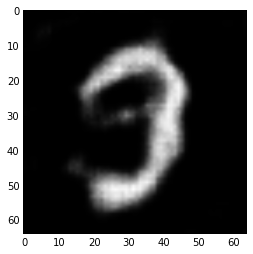

In [27]:
sample_zmb = floatX(np_rng.uniform(-1., 1., size=(100, nz)))
samples = np.asarray(_gen(sample_zmb))
plt.imshow(samples[0].reshape(64,64),'gray')

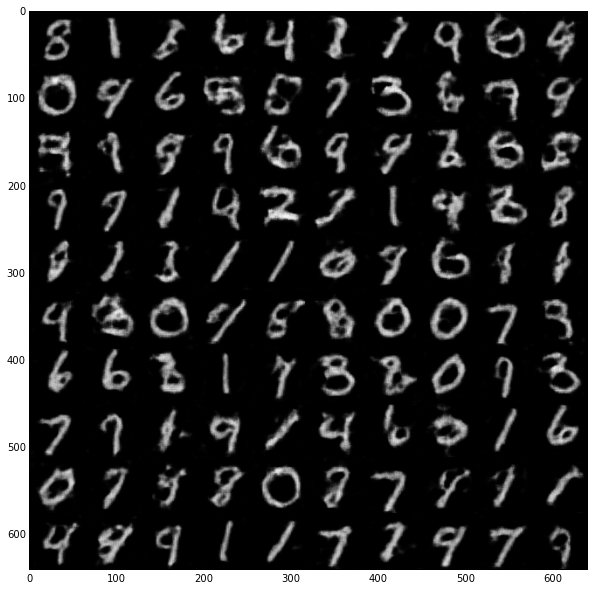

In [29]:
n = 10  # figure with 15x15 digits
digit_size = 64
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np_rng.uniform(-1., 1., size=(100, nz))
        z_sample=z_sample.astype(np.float32)
        x_decoded = _gen(z_sample)[0]
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

(array([ 573.,   10.,   10.,    8.,   16.,    7.,    5.,   13.,   14.,  128.]),
 array([  4.62138674e-19,   9.99975324e-02,   1.99995065e-01,
          2.99992597e-01,   3.99990129e-01,   4.99987662e-01,
          5.99985194e-01,   6.99982727e-01,   7.99980259e-01,
          8.99977791e-01,   9.99975324e-01]),
 <a list of 10 Patch objects>)

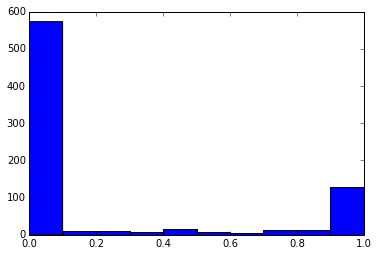

In [128]:
plt.hist(x_decoded.reshape(-1))